In [ ]:
NAME_STUDENT_1 = "Tianze Wang"
NAME_STUDENT_2 = "Egor Lomagin"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import openml as oml
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
from IPython.display import Markdown, display

In [3]:
sb.set(font_scale=2)
sb.set_style('white')

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [4]:
devnagari = oml.datasets.get_dataset(40923)
X, y = devnagari.get_data(target=devnagari.default_target_attribute)

In [5]:
display(Markdown(devnagari.description))

**Author**: Prashnna K Gyawali, Shailesh Acharya, Ashok Pant  
**Source**: [Computer Vision Research Group, Nepal](https://web.archive.org/web/20160105230017/http://cvresearchnepal.com/wordpress/dhcd/), [Kaggle](https://www.kaggle.com/rishianand/devanagari-character-set)   
**Please cite**: Acharya S., Pant A.K., Gyawali P.K.,”Deep Learning based large scale handwritten Devanagari Character Recognition” Proceeding of 9th International Conference on Software, Knowledge, Information Management & Applications  

**Character Recognition for Devanagari Script**
Over 92 thousand images (32x32 pixels) of 46 characters from Devanagari script. Includes the alphabet as well as the numbers. Devanagari is an Indic script and forms a basis for over 100 languages spoken in India and Nepal including Hindi, Marathi, Sanskrit, and Maithili. It comprises of 47 primary alphabets, 14 vowels, and 33 consonants, and 10 
digits. In addition, the alphabets are modified when a vowel is added to a 
consonant. There is no capitalization of alphabets, unlike Latin languages.

In [6]:
X.shape

(92000, 1024)

# Part 1

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
X_01, X_09, y_01, y_09 = train_test_split(X, y, train_size=0.1, stratify=y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_01, y_01, stratify=y_01)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

### Train and test

In [12]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

In [13]:
y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))

0.4865217391304348


In [14]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train);

In [15]:
y_pred_knn = knn.predict(X_test)
print(accuracy_score(y_test, y_pred_knn))

0.731304347826087


In [16]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train);

In [17]:
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.7604347826086957


### Train time and predictive performance measurements

In [18]:
from time import time

In [19]:
def measure_training_time_performance(estimator_constructor, X, y, train_sizes=[0.1, 0.2, 0.3]):
    training_times = []
    accuracy_scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    for t_size in tqdm_notebook(train_sizes):
        X_train_subsample, _, y_train_subsample, _ = train_test_split(X_train, y_train, train_size=t_size, stratify=y_train)
        estimator = estimator_constructor()
        start_train = time()
        estimator.fit(X_train_subsample, y_train_subsample)
        end_train = time()
        training_times.append(end_train - start_train)
        accuracy_scores.append(accuracy_score(y_test, estimator.predict(X_test)))
    return training_times, accuracy_scores
        

In [20]:
def plot_training_times(train_sizes, train_times, name=None, label=None):
    plt.plot(train_sizes, train_times, '-o', label=label)
    if name:
        plt.title('{0} training'.format(name))
    plt.xlabel('Train set size')
    plt.ylabel('Training time')

In [21]:
def plot_prediction_accuracy(train_sizes, prediction_accuracies, name=None, label=None):
    plt.plot(train_sizes, prediction_accuracies, '-o', label=label)
    if name:
        plt.title('{0} prediction'.format(name))
    plt.xlabel('Training set size')
    plt.ylabel('Prediction accuracy')

In [22]:
train_sizes = [0.05, 0.1, 0.15, 0.2, 0.25]

#### LogisticRegression

In [23]:
lr_times, lr_scores = measure_training_time_performance(lambda: LogisticRegression(), X, y,
                                                        train_sizes=train_sizes)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [24]:
plot_training_times(train_sizes, lr_times, 'LogisticRegression')

In [25]:
plot_prediction_accuracy(train_sizes, lr_scores, 'LogisticRegression')

For LogisticRegression training time grows rapidly (looks polynomial) with the increase of training set size.
If the default LogisticRegression solver is using SGD the time complexity of training is $ O(k n \bar p)$ where k is the number of iterations (epochs) and $\bar p$ is the average number of non-zero attributes per sample. This means that SGD is linear of training size, but number of iterations may also depend on traning size (in will take more steps for a model to converge for greater training size). Source: http://scikit-learn.org/stable/modules/sgd.html#complexity

Predictive accuracy of LogisticRegression dropped with the increase of training set size and then started increasing back. One explanation for this is that it happended at random and that on the splits with 0.1 and 0.15 training sizes there was different from data we used as test set and thus model performed worse on test set after training on this data. And splits 0.2 and 0.25 added more data like in test set and improved model performance on it.

#### KNN

In [26]:
knn_times, knn_scores = measure_training_time_performance(lambda: KNeighborsClassifier(), X, y,
                                              train_sizes=train_sizes)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [27]:
plot_training_times(train_sizes, knn_times, 'KNN')

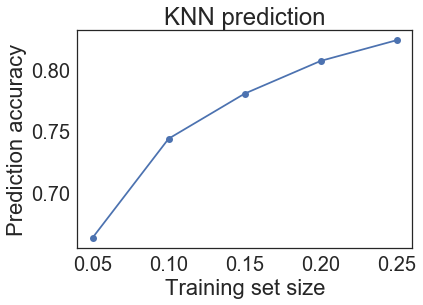

In [28]:
plot_prediction_accuracy(train_sizes, knn_scores, 'KNN')

KNN training time is very low (theoretically - a constant). All the classifier needs to do is to memorize the dataset. However time is not constant because more data is being copied and, probably, data is put in an easy to index data structure like KD-tree. This opertation has different than constant time complexity too.
Prediction accuracy of KNN grows with amount of data it has memorized because it has more samples to compare features to and there is higher probability to have find featureset of needeed class.

#### RandomForest

In [29]:
rf_times, rf_scores = measure_training_time_performance(lambda: RandomForestClassifier(), X, y,
                                            train_sizes=train_sizes)

Widget Javascript not detected.  It may not be installed or enabled properly.


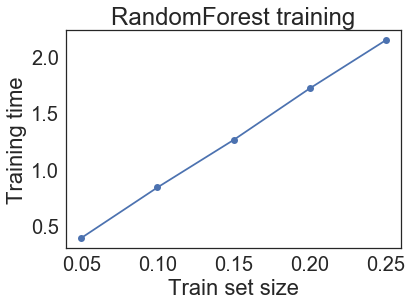

In [30]:
plot_training_times(train_sizes, rf_times, 'RandomForest')

In [31]:
plot_prediction_accuracy(train_sizes, rf_scores, 'RandomForest')

For random forest training time grows linear of tranining set size. Training of RF is fast and also can be easily parallelized, since all the trees in enseble are build independently.
More training set size gives better prediction accuracy.

In [32]:
plot_training_times(train_sizes, lr_times, label='LR')
plot_training_times(train_sizes, knn_times, label='KNN')
plot_training_times(train_sizes, rf_times, label='RF')
plt.title('Training time')
plt.legend()

In [33]:
plot_prediction_accuracy(train_sizes, lr_scores, label='LR')
plot_prediction_accuracy(train_sizes, knn_scores, label='KNN')
plot_prediction_accuracy(train_sizes, rf_scores, label='RF')
plt.title('Prediction accuracy')
plt.legend()

# Part 2

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

In [10]:
from sklearn.model_selection import GridSearchCV, KFold

### KNN n_neighbors optimisation

In [11]:
params_knn = {
    'n_neighbors': [1, 2, 3, 4] + list(range(5, 50, 10))
}

In [12]:
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, params_knn, scoring='accuracy', n_jobs=-1, cv=KFold(10, True), verbose=10)
grid_knn.fit(X_01, y_01)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed: 64.3min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 65.8min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 15, 25, 35, 45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [13]:
grid_knn.best_score_

0.7844565217391304

In [14]:
grid_knn.best_params_

{'n_neighbors': 1}

In [15]:
plt.plot(params_knn['n_neighbors'], grid_knn.cv_results_['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('Average cv accuracy')

For KNN best predictive performance on this dataset was achieved with `n_neighbors` parameter set to 1. Then for `n_neighbors` = 2 there was a drop in accuracy, which might have been caused by possibility of ties, then, for value 3 it went up again, for 4 and 5 was staying almost on the same level, and after that was dropping rapidly with the following increase of `n_neighbors`.

`n_neighbours` = 1 must be a good choice for this character recognition problem.

### RandomForest n_estimators optimization

In [16]:
params_rf = {
    'n_estimators': range(10, 110, 10)
}

In [17]:
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, params_rf, scoring='accuracy', n_jobs=-1, cv=KFold(10, True))
grid_rf.fit(X_01, y_01)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 110, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [18]:
grid_rf.best_score_

0.7734782608695652

In [19]:
grid_rf.best_params_

{'n_estimators': 100}

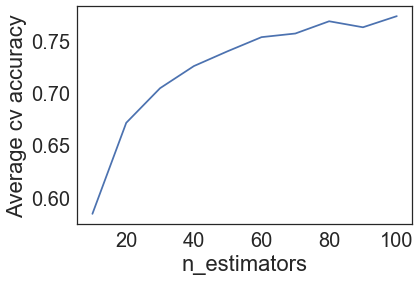

In [30]:
plt.plot(params_rf['n_estimators'], grid_rf.cv_results_['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('Average cv accuracy')

Predictive performance of RandomForest imporoves with the increase of `n_estimators` parameter, but improvements also slow down. Apart from that, there is a tradeoff between `n_estimators` parameter (and thus predictive quality) and model training and execution time.
This means that to get RandomForest model that is good for problem that is being solved `n_estimators` should be selected in such a way that:
- predictive performance is good enough;
- training time is low enough ("low enough" depends on the problem);
- model execution time (prediction) is low enough ("low enough" depends on the problem).

# Part 3

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold

In [13]:
from scipy.stats import randint

### Applying RandomizedSearchCV to tune RandomForest hyperparameters

In [14]:
rf_random_params = {
    'n_estimators': randint(10, 100),
    'max_features': randint(10, 500),
}

In [15]:
rf = RandomForestClassifier()

In [16]:
from time import time

In [17]:
rf_rs = RandomizedSearchCV(rf, rf_random_params, n_iter=10, n_jobs=-1, cv=KFold(10, True), verbose=10)

In [18]:

t_start = time()
rf_rs_scores = cross_val_score(rf_rs, X, y, cv=KFold(3, True))
t_end = time()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=91, max_features=316 ...............................
[CV] n_estimators=64, max_features=234 ...............................
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=64, max_features=234, score=0.8769155526573199, total= 7.8min
[CV]

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.9min


[CV]  n_estimators=64, max_features=234, score=0.8805021193348549, total= 7.8min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8844147375285295, total=14.7min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8778937072057386, total=14.8min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8785458102380176, total=14.8min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8744496983531713, total=14.8min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8762432740909832, total=14.8min
[CV]  n_estimators=91, max_features=316, score=0.8790151638676015, total=14.8min


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 15.1min


[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8785260068481983, total=14.8min
[CV] n_estimators=64, max_features=234 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8671123430621229, total=14.8min
[CV] n_estimators=82, max_features=306 ...............................
[CV] n_estimators=82, max_features=306 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8770585357899886, total=14.9min
[CV] n_estimators=82, max_features=306 ...............................
[CV]  n_estimators=91, max_features=316, score=0.8811348442850155, total=14.9min
[CV] n_estimators=82, max_features=306 ...............................
[CV]  n_estimators=64, max_features=234, score=0.8803390935767851, total= 7.9min
[CV] n_estimators=82, max_features=306 ...............................
[CV]  n_estimators=64, max_features=234, score=0.878036849828795, total= 8.0min
[CV] n_estimators=

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 23.1min


[CV]  n_estimators=64, max_features=234, score=0.8690689711397358, total= 7.9min
[CV] n_estimators=82, max_features=306 ...............................
[CV]  n_estimators=64, max_features=234, score=0.8708625468775477, total= 7.9min
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=64, max_features=234, score=0.8812978966248166, total= 7.9min
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.8578415389631562, total=  27.9s
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.8641995435278774, total=  28.0s
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.8655037495924356, total=  28.2s
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.867275395401924, total=  28.1s
[CV] n_estim

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 24.7min


[CV]  n_estimators=38, max_features=20, score=0.8653187673243111, total=  28.3s
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.8542312082178379, total=  29.1s
[CV] n_estimators=38, max_features=20 ................................
[CV]  n_estimators=38, max_features=20, score=0.8635251915864993, total=  28.0s
[CV] n_estimators=39, max_features=152 ...............................
[CV]  n_estimators=38, max_features=20, score=0.8702103375183434, total=  28.4s
[CV] n_estimators=39, max_features=152 ...............................
[CV]  n_estimators=82, max_features=306, score=0.8780567329638083, total=13.1min
[CV] n_estimators=39, max_features=152 ...............................
[CV]  n_estimators=82, max_features=306, score=0.8778937072057386, total=13.1min
[CV] n_estimators=39, max_features=152 ...............................
[CV]  n_estimators=82, max_features=306, score=0.8781999021685961, total=13.1min
[CV] n_esti

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 29.1min


[CV]  n_estimators=82, max_features=306, score=0.8788521115278004, total=13.2min
[CV] n_estimators=39, max_features=152 ...............................
[CV]  n_estimators=39, max_features=152, score=0.8669709814150636, total= 3.3min
[CV] n_estimators=48, max_features=330 ...............................
[CV]  n_estimators=39, max_features=152, score=0.8729822272949617, total= 3.2min
[CV] n_estimators=48, max_features=330 ...............................
[CV]  n_estimators=39, max_features=152, score=0.8617316158486874, total= 3.2min
[CV] n_estimators=48, max_features=330 ...............................
[CV]  n_estimators=39, max_features=152, score=0.8666231860427197, total= 3.2min
[CV] n_estimators=48, max_features=330 ...............................
[CV]  n_estimators=39, max_features=152, score=0.8654818196641122, total= 3.2min
[CV] n_estimators=48, max_features=330 ...............................
[CV]  n_estimators=39, max_features=152, score=0.864992662644709, total= 3.2min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 36.4min


[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=82, max_features=306, score=0.8746127506929724, total=13.2min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8611020541245517, total= 8.2min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8583306162373655, total= 8.2min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8711886515571499, total= 8.2min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8648516465601565, total= 8.3min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8648296103049079, total= 8.2min
[CV] n_estimators=19, max_features=416 ...............................
[CV]  n_estimator

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 44.1min


[CV]  n_estimators=19, max_features=416, score=0.8274906244904614, total= 4.1min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=19, max_features=416, score=0.8206424262188162, total= 4.1min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=19, max_features=416, score=0.822436001956628, total= 4.1min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=48, max_features=330, score=0.8615685635088863, total= 8.3min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=19, max_features=416, score=0.8217837925974237, total= 4.1min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=19, max_features=416, score=0.8120006522093592, total= 4.0min
[CV] n_estimators=58, max_features=157 ...............................
[CV]  n_estimators=19, max_features=416, score=0.8173813794227948, total= 4.1min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 47.2min


[CV]  n_estimators=41, max_features=109, score=0.8694163677861102, total= 2.4min
[CV] n_estimators=41, max_features=109 ...............................
[CV]  n_estimators=41, max_features=109, score=0.8741235936735692, total= 2.4min
[CV] n_estimators=41, max_features=109 ...............................
[CV]  n_estimators=58, max_features=157, score=0.8778937072057386, total= 4.9min
[CV] n_estimators=41, max_features=109 ...............................
[CV]  n_estimators=58, max_features=157, score=0.8863525191586499, total= 4.9min
[CV] n_estimators=41, max_features=109 ...............................
[CV]  n_estimators=58, max_features=157, score=0.8781999021685961, total= 4.9min
[CV] n_estimators=82, max_features=18 ................................
[CV]  n_estimators=58, max_features=157, score=0.8788521115278004, total= 4.9min
[CV] n_estimators=82, max_features=18 ................................
[CV]  n_estimators=58, max_features=157, score=0.8760802217511822, total= 4.9min
[CV] n_

[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 50.3min remaining:  6.9min


[CV]  n_estimators=82, max_features=18, score=0.8901027229740747, total= 1.0min
[CV]  n_estimators=82, max_features=18, score=0.8894685360286926, total= 1.0min
[CV]  n_estimators=41, max_features=109, score=0.8788521115278004, total= 2.6min
[CV]  n_estimators=82, max_features=18, score=0.8891244089352682, total= 1.0min
[CV]  n_estimators=41, max_features=109, score=0.8662970813631176, total= 2.6min
[CV]  n_estimators=82, max_features=18, score=0.8884721995760639, total= 1.0min
[CV]  n_estimators=82, max_features=18, score=0.89091798467308, total= 1.0min
[CV]  n_estimators=82, max_features=18, score=0.8842328387412359, total= 1.0min
[CV]  n_estimators=82, max_features=18, score=0.8887983042556661, total=  52.5s
[CV]  n_estimators=82, max_features=18, score=0.8922224033914886, total=  50.2s
[CV]  n_estimators=41, max_features=109, score=0.869232023479537, total= 2.3min
[CV]  n_estimators=41, max_features=109, score=0.877873797488994, total= 2.3min


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 51.4min finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=25, max_features=41 ................................
[CV] n_estimators=65, max_features=371 ...............................
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.8542549722856211, total=  34.8s
[CV] 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   37.3s


[CV]  n_estimators=25, max_features=41, score=0.8492011737854581, total=  35.5s
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.844962504075644, total=  35.5s
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.8486874286646013, total=  35.9s
[CV]  n_estimators=25, max_features=41, score=0.8468938529267895, total=  35.6s
[CV] n_estimators=65, max_features=371 ...............................
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.8553725745964454, total=  37.4s
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.847872166965596, total=  37.5s
[CV] n_estimators=65, max_features=371 ...............................
[CV]  n_estimators=25, max_features=41, score=0.8495026903636067, total=  37.4s
[CV]  n_estimato

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   44.9s


[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=25, max_features=41, score=0.8495026903636067, total=  38.9s
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=18, max_features=434, score=0.822464949462015, total= 4.0min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=18, max_features=434, score=0.8063253994131073, total= 4.0min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=18, max_features=434, score=0.8105640691229214, total= 4.0min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=18, max_features=434, score=0.8126528615685635, total= 4.0min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8641995435278774, total=12.5min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 12.8min


[CV]  n_estimators=18, max_features=434, score=0.8141203326267732, total= 4.0min
[CV] n_estimators=18, max_features=434 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8684167617805315, total=12.4min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8606129768503423, total=12.4min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8641774009457036, total=12.4min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8671123430621229, total=12.4min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=65, max_features=371, score=0.8628729822272949, total=12.5min
[CV]  n_estimators=65, max_features=371, score=0.8728191749551606, total=12.4min
[CV] n_estimators=19, max_features=396 ...............................
[CV] n_

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.4min


[CV]  n_estimators=18, max_features=434, score=0.8141203326267732, total= 4.1min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=18, max_features=434, score=0.8229251589760314, total= 4.1min
[CV] n_estimators=19, max_features=396 ...............................
[CV]  n_estimators=18, max_features=434, score=0.8134681232675689, total= 4.1min
[CV] n_estimators=87, max_features=265 ...............................
[CV]  n_estimators=18, max_features=434, score=0.81363117560737, total= 4.1min
[CV] n_estimators=87, max_features=265 ...............................
[CV]  n_estimators=19, max_features=396, score=0.8164329964134334, total= 3.9min
[CV] n_estimators=87, max_features=265 ...............................
[CV]  n_estimators=19, max_features=396, score=0.8071405282034562, total= 3.9min
[CV] n_estimators=87, max_features=265 ...............................
[CV]  n_estimators=19, max_features=396, score=0.8125203782197588, total= 3.9min
[CV] n_es

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.2min


[CV]  n_estimators=19, max_features=396, score=0.822272949616827, total= 3.9min
[CV] n_estimators=87, max_features=265 ...............................
[CV]  n_estimators=19, max_features=396, score=0.8188488504810044, total= 3.9min
[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=19, max_features=396, score=0.8214576879178216, total= 3.9min
[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8827844799478317, total=12.0min
[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8837626344962504, total=12.1min
[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8757743723508314, total=12.1min
[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8798304255666068, total=12.0min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 29.5min


[CV] n_estimators=43, max_features=397 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8767324311103865, total=12.2min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=87, max_features=265, score=0.8814609489646177, total=12.2min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=43, max_features=397, score=0.8567003586566677, total= 9.0min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=43, max_features=397, score=0.8498532768177373, total= 9.0min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=43, max_features=397, score=0.85507010107597, total= 8.9min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=43, max_features=397, score=0.8571661503342572, total= 8.9min
[CV] n_estimators=42, max_features=465 ...............................
[CV]  n_estimators=

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 39.2min


[CV]  n_estimators=50, max_features=26, score=0.8791979132702967, total=  46.0s
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=42, max_features=465, score=0.8480599934789697, total=10.1min
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=42, max_features=465, score=0.8477339419628301, total=10.1min
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=42, max_features=465, score=0.8472448646886208, total=10.0min
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=42, max_features=465, score=0.8537420511984347, total=10.0min
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=50, max_features=26, score=0.873981089012064, total=  47.8s
[CV] n_estimators=50, max_features=26 ................................
[CV]  n_estimators=50, max_features=26, score=0.8726561226153595, total=  48.0s
[CV] n_esti

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 41.0min


[CV]  n_estimators=43, max_features=181, score=0.8690903162699707, total= 4.1min
[CV] n_estimators=43, max_features=181 ...............................
[CV]  n_estimators=43, max_features=181, score=0.8730029344636453, total= 4.1min
[CV] n_estimators=43, max_features=181 ...............................
[CV]  n_estimators=43, max_features=181, score=0.868112161721552, total= 4.1min
[CV] n_estimators=43, max_features=181 ...............................
[CV]  n_estimators=43, max_features=181, score=0.8687428664601337, total= 4.1min
[CV] n_estimators=43, max_features=181 ...............................
[CV]  n_estimators=43, max_features=181, score=0.864992662644709, total= 4.1min
[CV] n_estimators=53, max_features=405 ...............................
[CV]  n_estimators=43, max_features=181, score=0.8666231860427197, total= 4.1min
[CV] n_estimators=53, max_features=405 ...............................
[CV]  n_estimators=42, max_features=465, score=0.8467308005869885, total=10.2min
[CV] n_es

[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 48.9min remaining:  6.7min


[CV] n_estimators=53, max_features=405 ...............................
[CV]  n_estimators=43, max_features=181, score=0.8731452796347627, total= 4.1min
[CV]  n_estimators=43, max_features=181, score=0.8676015000815261, total= 4.1min
[CV]  n_estimators=53, max_features=405, score=0.85507010107597, total=10.1min
[CV]  n_estimators=53, max_features=405, score=0.8646886208020867, total=10.6min
[CV]  n_estimators=53, max_features=405, score=0.8641774009457036, total= 9.1min
[CV]  n_estimators=53, max_features=405, score=0.8599380401108756, total= 9.5min
[CV]  n_estimators=53, max_features=405, score=0.8558617316158487, total=10.0min
[CV]  n_estimators=53, max_features=405, score=0.8716778085765531, total= 9.7min
[CV]  n_estimators=53, max_features=405, score=0.8571661503342572, total= 9.9min
[CV]  n_estimators=53, max_features=405, score=0.857189435930877, total=10.2min
[CV]  n_estimators=53, max_features=405, score=0.8643404532855047, total= 9.7min
[CV]  n_estimators=53, max_features=405, 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 58.9min finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=52, max_features=142 ...............................
[CV] n_estimators=12, max_features=353 ...............................
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=12, max_features=353, score=0.7981741115096185, total= 2.2min
[CV]

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min


[CV]  n_estimators=12, max_features=353, score=0.7936093902836648, total= 2.2min
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8765895011411803, total= 3.9min
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8723508314313662, total= 3.9min
[CV]  n_estimators=52, max_features=142, score=0.8705364421979456, total= 3.9min
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8834365829801109, total= 3.9min
[CV]  n_estimators=52, max_features=142, score=0.8800130420606456, total= 3.9min
[CV]  n_estimators=52, max_features=142, score=0.8666231860427197, total= 3.9min


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.1min


[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8912440893526822, total= 3.9min
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8790151638676015, total= 4.0min
[CV]  n_estimators=52, max_features=142, score=0.8785260068481983, total= 4.0min
[CV] n_estimators=12, max_features=353 ...............................
[CV]  n_estimators=52, max_features=142, score=0.8752649600521768, total= 4.0min
[CV] n_estimators=12, max_features=353 ...............................
[CV] n_estimators=47, max_features=309 ...............................
[CV] n_estimators=47, max_features=309 ...............................
[CV] n_estimators=47, max_features=309 ...............................
[CV] n_estimators=47, max_features=309 ...............................
[CV]  n_estimators=12, max_features=353, score=0.792794261493316, total= 2.3min
[CV] n_estimators=47, max_fe

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.3min


[CV]  n_estimators=12, max_features=353, score=0.7925974237730311, total= 2.2min
[CV] n_estimators=47, max_features=309 ...............................
[CV]  n_estimators=12, max_features=353, score=0.7953693135496495, total= 2.2min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=12, max_features=353, score=0.7911299527148214, total= 2.2min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=27, max_features=110, score=0.858656667753505, total= 1.6min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=27, max_features=110, score=0.8521356374307141, total= 1.6min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=27, max_features=110, score=0.8509944571242256, total= 1.6min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=27, max_features=110, score=0.8522986631887838, total= 1.6min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.2min


[CV]  n_estimators=47, max_features=309, score=0.8741441147701337, total= 7.5min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=47, max_features=309, score=0.8651776980762961, total= 7.5min
[CV] n_estimators=27, max_features=110 ...............................
[CV]  n_estimators=47, max_features=309, score=0.8651776980762961, total= 7.5min
[CV] n_estimators=59, max_features=422 ...............................
[CV]  n_estimators=47, max_features=309, score=0.868112161721552, total= 7.5min
[CV] n_estimators=59, max_features=422 ...............................
[CV]  n_estimators=47, max_features=309, score=0.8534159465188326, total= 7.5min
[CV] n_estimators=59, max_features=422 ...............................
[CV]  n_estimators=47, max_features=309, score=0.8662970813631176, total= 7.5min
[CV] n_estimators=59, max_features=422 ...............................
[CV]  n_estimators=27, max_features=110, score=0.8552095222566444, total= 1.6min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.9min


[CV]  n_estimators=47, max_features=309, score=0.8628729822272949, total= 7.6min
[CV] n_estimators=59, max_features=422 ...............................
[CV]  n_estimators=47, max_features=309, score=0.8693950758193381, total= 7.6min
[CV] n_estimators=10, max_features=73 ................................
[CV]  n_estimators=47, max_features=309, score=0.8693950758193381, total= 7.6min
[CV] n_estimators=10, max_features=73 ................................
[CV]  n_estimators=10, max_features=73, score=0.7864362569285948, total=  24.0s
[CV] n_estimators=10, max_features=73 ................................
[CV]  n_estimators=10, max_features=73, score=0.7706227583958265, total=  23.7s
[CV] n_estimators=10, max_features=73 ................................
[CV]  n_estimators=10, max_features=73, score=0.7820345614607108, total=  24.1s
[CV] n_estimators=10, max_features=73 ................................
[CV]  n_estimators=10, max_features=73, score=0.7786110205412455, total=  23.9s
[CV] n_esti

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 15.6min


[CV]  n_estimators=10, max_features=73, score=0.779553236588945, total=  24.8s
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=10, max_features=73, score=0.7727050383172999, total=  24.9s
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8557222041082491, total= 7.9min
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8503423540919465, total= 8.0min
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=59, max_features=422, score=0.8707205738506684, total=12.8min
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=59, max_features=422, score=0.860123899576133, total=12.9min
[CV] n_estimators=35, max_features=446 ...............................
[CV]  n_estimators=59, max_features=422, score=0.8635474404955983, total=12.8min
[CV] n_esti

[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 26.7min


[CV]  n_estimators=59, max_features=422, score=0.8702103375183434, total=12.8min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8421910661884577, total= 8.0min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.846429735898272, total= 8.0min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8364585031795206, total= 8.0min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8447741725093755, total= 8.0min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8530898418392304, total= 8.1min
[CV] n_estimators=93, max_features=152 ...............................
[CV]  n_estimators=35, max_features=446, score=0.8527637371596283, total= 8.1min
[CV] n_e

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 34.4min


[CV]  n_estimators=93, max_features=152, score=0.8773846404695907, total= 7.5min
[CV] n_estimators=61, max_features=371 ...............................
[CV]  n_estimators=93, max_features=152, score=0.8848850481004402, total= 7.5min
[CV] n_estimators=61, max_features=371 ...............................
[CV]  n_estimators=93, max_features=152, score=0.8887983042556661, total= 7.6min
[CV] n_estimators=61, max_features=371 ...............................
[CV]  n_estimators=93, max_features=152, score=0.8901027229740747, total= 7.5min
[CV] n_estimators=61, max_features=371 ...............................
[CV]  n_estimators=93, max_features=152, score=0.8948312408283059, total= 7.5min
[CV] n_estimators=26, max_features=447 ...............................
[CV]  n_estimators=93, max_features=152, score=0.8910810370128811, total= 7.5min
[CV] n_estimators=26, max_features=447 ...............................
[CV]  n_estimators=61, max_features=371, score=0.8774046299315292, total=11.7min
[CV] n_

[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 46.9min remaining:  6.4min


[CV] n_estimators=26, max_features=447 ...............................
[CV]  n_estimators=61, max_features=371, score=0.8669492907223219, total=11.7min
[CV]  n_estimators=61, max_features=371, score=0.8679276047611283, total=11.7min
[CV]  n_estimators=26, max_features=447, score=0.8345288555591783, total= 6.0min
[CV]  n_estimators=26, max_features=447, score=0.8363221388979458, total= 6.0min
[CV]  n_estimators=26, max_features=447, score=0.8230882113158324, total= 6.0min
[CV]  n_estimators=26, max_features=447, score=0.828631990869069, total= 6.0min
[CV]  n_estimators=26, max_features=447, score=0.8300994619272787, total= 5.8min
[CV]  n_estimators=61, max_features=371, score=0.8723300179357574, total=11.6min
[CV]  n_estimators=61, max_features=371, score=0.8718408609163542, total=11.5min
[CV]  n_estimators=26, max_features=447, score=0.8322191423446926, total= 5.8min
[CV]  n_estimators=26, max_features=447, score=0.8496657427034078, total= 5.6min
[CV]  n_estimators=26, max_features=447

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 52.5min finished


In [19]:
print("running time {:.2f}s".format(t_end- t_start))

running time 10659.14s


In [20]:
rf_rs_scores.mean()

0.8908260961463252

In [29]:
print(rf_rs_scores.max())
print(rf_rs_scores.min())

0.8933381158900446
0.8874686144715819


In [ ]:
We applied 3-fold cross_val_score to 10-fold RandomizedSearchCV with RandomForestClassifier. 

### Applying grid search to tune RandomForest hyperparameters

In [21]:
rf_grid_params = {
    'n_estimators': [10,20,30,50,80,140],
    'max_features': [10,20,40,70,100,200],
}

In [22]:
rf = RandomForestClassifier()

In [23]:
rf_grid = GridSearchCV(rf, rf_grid_params, n_jobs=-1, cv=KFold(10, True), verbose=10)

In [24]:
from time import time
t_start = time()
rf_grid.fit(X_01, y_01)
t_end = time()
print("the time it takes = {:.2f}s".format(t_end - t_start))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  3.5min
[Paralle

the time it takes = 969.28s


In [25]:
rf_grid.best_score_

0.7863043478260869

In [26]:
rf_cv_df = pd.DataFrame()
rf_cv_df['n_estimators'] = rf_grid.cv_results_['param_n_estimators'].data
rf_cv_df['max_features'] = rf_grid.cv_results_['param_max_features'].data
rf_cv_df['accuracy'] = rf_grid.cv_results_['mean_test_score']

In [29]:
sb.heatmap(rf_cv_df.pivot('n_estimators', 'max_features', 'accuracy'), xticklabels=True, yticklabels=True, annot=True, annot_kws={'size':14})

**Unfortunatelly 5 hours before submission we lost results acquired on the whole dataset so we had to redo it on 10%. Conclusions stayed the same**

This heat map shows overall trend of improving model accuracy with the increase of numer of estimators. Very interesting result comes from observing model behaviour with different max_features parameters. We can see that best accuracy is achieved with max_features = 20 and max_features = 40. Both of these values are close to empirically recommended max_features = sqrt(n_features) = 32.